# Parsing top-down (caso deterministico)

In [ ]:
from liblet import (
    Grammar, 
    Derivation,
    ProductionGraph, 
    Stack, 
    Table, 
    closure, 
    warn
)

from L15 import suffixes, compute_εfirst

Come osservato nella lezione precedente, data una derivazione parziale $S\#\overset{*}{\to}xA\gamma\#$ (ossia avendo in pila $\#\gamma A$) della parola $xay$ (di cui resta quindi da esaminare $ay$), si pone il problema di decidere quale alternativa $A \to \alpha_1 | \alpha_2 | \dots | \alpha_k$ scegliere.

Se $a$ appartenesse ad uno solo $\operatorname{FIRST}(\alpha_i\gamma\#)$ (per un assegnato $1\leq i\leq k$) la scelta non potrebbe che ricadere su $A\to\alpha_i$, ma ci sono due problemi in questo approccio:

* l'*unicità*: dobbiamo restringerci a $\operatorname{LL}(1)$ per poterla garantire;
* il *calcolo* di $\operatorname{FIRST}(\alpha_i\gamma\#)$: sebbene gli $\alpha_i$ siano noti e in un numero finito, non lo sono i $\gamma$, quindi in generale non basta una precomputazione!

Come abbiamo visto, il secondo problema è molto facile da risolvere se la grammatica non contiene ε-produzioni: in tal caso $\operatorname{FIRST}(\alpha_i\gamma\#) = \operatorname{FIRST}(\alpha_i) = \operatorname{FIRST}(X)$, dove $X$ è il primo simbolo di $\alpha_i$ e considerando che $\alpha_i$ non è *trasparente* (ossia $\alpha_i\overset{*}{\to}\varepsilon$).

Ma come scegliere se $\alpha_i$ è trasparente? Se $a$ appartenesse ad uno solo degli insiemi„
$$
\bigcup_{\gamma : S\#\overset{*}{\to}x \alpha_i\gamma\#} \operatorname{FIRST}(\alpha_i\gamma\#) $$
(per un assegnato $1\leq i\leq k$), di nuovo la scelta non potrebbe che ricadere su $A\to\alpha_i$. La decisione può essere presa considerando l'insieme
$$
\bigcup_{\gamma : S\overset{*}{\to}x A\gamma\#} \operatorname{FIRST}(\gamma\#) = 
\operatorname{FOLLOW}(A) = \{t \in T | S\#\overset{*}{\to}x A\gamma\# \overset{*}{\to}x A t \gamma' \}
$$
dei terminali che seguono immediatamente $A$ in una qualunque derivazione. 

Mettendo le cose assieme, data la pila $(A, a)$ e la restante parola $ay$, può essere scelta l'alternativa $A\to\alpha$ a patto che sia l'*unica* tra tutte quelle di $A$ per cui:

* $\alpha$ non è trasparente e $a\in \operatorname{FIRST}(\alpha)$, 
* oppure $a\in \operatorname{FOLLOW}(A)$.

## Strong LL(1)

L'insieme $\operatorname{FOLLOW}$ può essere precomputato, attraverso una chiusura, come segue:

In [ ]:
def compute_follow(G, FIRST):
    
    FOLLOW = Table(1, set)
    FOLLOW[G.S] |= {'#'}
    
    @closure
    def complete_follow(FOLLOW):
        for X, ω in G.P:
            for γ in suffixes(ω): # X -> α A β (α è mangiato dal suffisso)
                A, *β = γ
                if A not in G.N: continue
                FOLLOW[A] |= FIRST[β] - {'ε'}
                if 'ε' in FIRST[β]: FOLLOW[A] |= FOLLOW[X]
        return FOLLOW
    
    return complete_follow(FOLLOW)

L'osservazione cruciale è che, dato $X\to\alpha A \beta$, si ha che 
$\operatorname{FOLLOW}(A)$ contiene sia $\operatorname{FIRST}(\beta)$ (tolto eventualmente $\varepsilon$) che $\operatorname{FOLLOW}(X)$ se $\beta\overset{*}{\to}\varepsilon$; infatti se $S\#\overset{*}{\to}x X\gamma\to x\alpha A \beta\gamma\# \overset{*}{\to} x\alpha A\gamma\#$ quindi quel che segue $X$ segiurà anche $A$.

Proviamo ad usare una la grammatica dell'ultima lezione per fare un esempio.

In [ ]:
# fig. 8.9, pag. 242

G = Grammar.from_string("""
Session -> Facts Question | ( Session ) Session
Facts -> Fact Facts | ε
Fact -> ! STRING
Question -> ? STRING
""")

In [ ]:
FIRST = compute_εfirst(G)
FIRST.restrict_to({(N, ) for N in G.N})

In [ ]:
FOLLOW = compute_follow(G, FIRST)
FOLLOW

Ora è possibile precomputare una vera e propria tabella, per ciascuna produzione $A\to\alpha$ tenendo traccia dei conflitti tra $\operatorname{FIRST}$ e $\operatorname{FOLLOW}$

In [ ]:
def compute_table(G, FIRST, FOLLOW):
    
    TABLE = Table(2)
    FIRST_TABLE = Table(2)
    FOLLOW_TABLE = Table(2)

    for P in G.P:
        A, α = P
        for a in FIRST[α] - {'ε'}:
            if FIRST_TABLE[A, a] is not None:
                warn('First/first conflict on ({}, {}) for production {}'.format(A, a, P))
            else:
                FIRST_TABLE[A, a] = P
                TABLE[A, a] = P
        if 'ε' in FIRST[α]:
            for a in FOLLOW[A]:
                if FIRST_TABLE[A, a] is not None:
                    warn('First/follow conflict on ({}, {}) for production {}'.format(A, a, P))
                if FOLLOW_TABLE[A, a] is not None:
                    warn('Follow/follow conflict on ({}, {}) for production {}'.format(A, a, P))
                if FIRST_TABLE[A, a] is None and FOLLOW_TABLE[A, a] is None:
                    FOLLOW_TABLE[A, a] = P
                    TABLE[A, a] = P
    return TABLE

Possiamo costruire la tabella per la grammatica dell'esempio precedente

In [ ]:
TABLE = compute_table(G, FIRST, FOLLOW)
TABLE

La costruzione della parser *strong* è molto simile a quella *full* della precedente lezione, ma ora la tabella è una vera e propria tabella e basta consultarla per la coppia $(A, a)$, non c'è bisogno di guardare tutta la pila!

In [ ]:
def parse(G, TABLE, INPUT):
    deriv = Derivation(G)
    rest = tuple(INPUT) + ('#', )
    stack = Stack(['#', G.S])
    while stack:
        top = stack.pop()
        if top == 'ε': continue
        first, *other = rest
        if top in G.T | {'#'}:
            if first == top: 
                rest = other
            else:
                warn('Expecting {}, got {}.'.format(top, rest[0]))
                return None
        else:
            P = TABLE[top, first]
            if P is None:
                warn('No prediction for ({}, {}) at {}.'.format(top, first, deriv) )
                return None                 
            deriv = deriv.leftmost(P)
            for X in reversed(P.rhs): stack.push(X)
    return deriv

Facciamo un esempio sulla solita grammatica

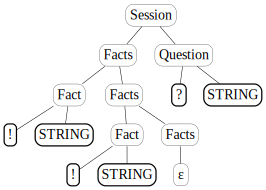

In [ ]:
d = parse(G, TABLE, '! STRING ! STRING ? STRING #'.split())
ProductionGraph(d)

### Consideriamo i vari casi di conflitto attraverso degli esempi

Introduciamo una funzione di comodo che faccia i vari passi di comptuazione…

In [ ]:
def fft(G):
    FIRST = compute_εfirst(G)
    FOLLOW = compute_follow(G, FIRST)
    FF = Table(2)
    for N in G.N: 
        FF[N, 'First'] = FIRST[(N, )]
        FF[N, 'Follow'] = FOLLOW[N]
    return FF, compute_table(G, FIRST, FOLLOW)

#### Caso first/first

In [ ]:
G = Grammar.from_string("""
S -> a | A
A -> a
""")

In [ ]:
FF, TABLE = fft(G)

First/first conflict on (S, a) for production S -> A


In [ ]:
FF

In [ ]:
TABLE

#### Caso first/follow

In [ ]:
G = Grammar.from_string("""
S -> A a
A -> a | ε
""")

In [ ]:
FF, TABLE = fft(G)

First/follow conflict on (A, a) for production A -> ε


In [ ]:
FF

In [ ]:
TABLE

#### Caso follow/follow

In [ ]:
G = Grammar.from_string("""
S -> A a 
A -> B | C
B -> ε
C -> ε
""")

In [ ]:
FF, TABLE = fft(G) 

Follow/follow conflict on (A, a) for production A -> C


In [ ]:
FF

In [ ]:
TABLE

## Fattorizzazione ed eliminazione dei conflitti

In presenza di due alternative $A\to \alpha\beta|\alpha\gamma$ con $\alpha$ non trasparente è evidente che sia impossibile scegliere sulla base di $\operatorname{FIRST}(\alpha)$ che riguarda entrambe le alternative! Una possibile soluzione consiste nel "fattorizzare" $\alpha$ mendiante l'introduzione di un nuovo non terminale $N$ cambiando le produzioni in $A\to \alpha N$ e $N\to \beta|\gamma$ sperando che $\operatorname{FIRST}(\beta)$ e $\operatorname{FIRST}(\gamma)$ siano disigunti.

Proviamo ad usare, come esempio, una grammatica per operazioni aritmetiche in cui ogni operatore coinvolga esattamente due sottoespressioni:

In [ ]:
G = Grammar.from_string("""
E  -> T + T | T
T  -> F * F | F 
F  -> ( E ) | i
""")

Ci sono conflitti…

In [ ]:
FF, TABLE = fft(G) 

First/first conflict on (E, () for production E -> T
First/first conflict on (E, i) for production E -> T
First/first conflict on (T, i) for production T -> F
First/first conflict on (T, () for production T -> F


In [ ]:
FF

In [ ]:
TABLE

Che possono essere risolti fattorizzando sia `T` che `F`

In [ ]:
G = Grammar.from_string("""
E  -> T E’
E’ -> + T | ε
T  -> F F’
F’ -> * F | ε
F  -> ( E ) | i
""")

In [ ]:
FF, TABLE = fft(G) 

In [ ]:
TABLE

Tentiamo il parse

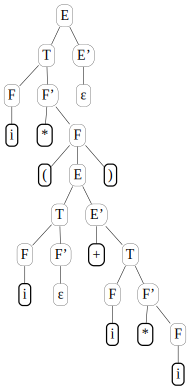

In [ ]:
ProductionGraph(parse(G, TABLE, 'i * ( i + i * i )'.split()))

La grammatica così fattorizzata si presta molto bene ad evitare la necessità di parentesizzare coppie di operandi, pur rispettando l'associatività

In [ ]:
G = Grammar.from_string("""
E  -> T E’
E’ -> + T E’| ε
T  -> F F’
F’ -> * F F’ | ε
F  -> ( E ) | i
""")

In [ ]:
FF, TABLE = fft(G) 

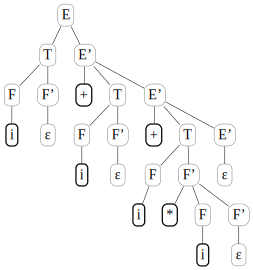

In [ ]:
ProductionGraph(parse(G, TABLE, 'i + i + i * i'.split()))

## Parse ricorsivo dicendente con look-ahead

Costruiamo ora un parser ricorsivo discendende (come quello sviluppato in [L13](L13.ipynb)) che usi le informazioni della tabella `TABLE` per decidere quali chiamate ricorsive fare (in funzione delle produzioni contenute nella tabella).

Per prima cosa ci serve un meccanismo per "consumare" i cartteri dell'input e tenere traccia del *look-ahead* ossia del prossimo carattere da leggere.

In [ ]:
def consume(t):        
    global look_ahead
    if look_ahead != t:
        warn('Expecting {}, found {}'.format(t, look_ahead))
    else:
        look_ahead = next(input_iterator, '#')

Ora, per ciascun non terminale, tramutiamo la riga relativa in una serie di chiamate ricorsive distinguendo tra le varie colonne grazie al *look-ahead*

In [ ]:
def parse_E():
    if look_ahead in {'i', '('}:
        parse_T()
        parse_Ep()
    else:
        warn('Error parsing E')

In [ ]:
def parse_Ep():
    if look_ahead in {')', '#'}:
        pass # questa è l'ε-produzione
    elif look_ahead == '+':
        consume('+')
        parse_T()
        parse_Ep()
    else:
        warn('Error parsing E’')

In [ ]:
def parse_T():
    if look_ahead in {'i', '('}:
        parse_F()
        parse_Fp()
    else:
        warn('Error parsing T')


In [ ]:
def parse_Fp():
    if look_ahead in {'+', ')', '#'}:
        pass
    elif look_ahead == '*':
        consume('*')
        parse_F()
        parse_Fp()
    else:
        warn('Error parsing F’')

In [ ]:
def parse_F():
    if look_ahead == 'i':
        consume('i')
    elif look_ahead == '(':
        consume('(')
        x = parse_E()
        consume(')')
        return x
    else:
        warn('Error parsing F')

Possiamo collaudare il parser costruendo un iteratore sull'input, che sarà usato da `consume` per verificare la correttezza del passo di derivazione e aggiornare il *look-ahead*

In [ ]:
input_iterator = iter('( i * i ) + i + i'.split())
look_ahead = next(input_iterator)

parse_E() # Non viene restituito nulla, ossia la parola è riconosciuta

In [ ]:
input_iterator = iter('( i i ) * i'.split())
look_ahead = next(input_iterator)

parse_E() # La parola non è una espressione valida, quindi viene restituito un errore

Error parsing F’
Error parsing E’
Expecting ), found i
Error parsing F’
Error parsing E’


### <span style="color: red;">Esercizi per casa</span>

Non è difficile scrivere un *generatore di parser* come abbiamo fatto nella lezione [L13](L13.ipynb) che tenga conto del *look-ahead*.

Un altro esercizio interessante potrebbe essere quello di modificare le procedure sopra riportate (o il generatore di parser) in modo che restituisca la derivazione ottenuta, sempre seguendo l'esmpio di quanto fatto nella lezione [L13](L13.ipynb).

## <span style="color: red">Approfondimento per casa</span> La valutazione di espressioni

Il discorso si complica un po' se volessimo ottenere il valore dell'espressione aritmetica, in quel caso l'atomo `i` andrebbe rimpiazzato da un numero; ci sarebbe bisogno cioè di introdurre un passo di tokenizzazione, come è stato fatto ad esempio nella pillola [L03-Pill](L03-Pill.ipynb).

In [ ]:
from re import finditer

def make_consume(expression):
    input_iterator = iter(_.group() for _ in finditer(r'[(+*)]|\d+', expression))    
    def next_token():
        global look_ahead, value
        token = next(input_iterator, '#')
        if token in {'+', '*', '(', ')', '#'}:
            look_ahead = token
            value = None
        else:
            look_ahead = 'i'
            value = int(token)
    next_token()
    def consume(t):        
        if look_ahead != t:
            warn('Expecting {}, found {}'.format(t, look_ahead))
        else:
            next_token()
    return consume

Vediamone un esempio d'uso: il tokenizzatore memorizza (oltre al *look-ahead*) anche il valore numerico degli atomi che incontra in una variabile globale di nome `value`.

In [ ]:
consume = make_consume('23 * 2 + (2+ 4)')

while True:
    if look_ahead == '#': break
    print(value if look_ahead == 'i' else look_ahead)
    consume(look_ahead)

23
*
2
+
(
2
+
4
)


Siamo pronti ad adattare il parser di prima in modo tale che, invece di limitarsi ad emettere *warning*, ciascuna sua procedura restituisca il valore della sottoespressione che ha elaborato.

In [ ]:
def eval_E():
    if look_ahead in {'i', '('}:
        res = eval_T()
        res += eval_Ep()
        return res
    else:
        warn('Error parsing E')

def eval_Ep():
    if look_ahead in {')', '#'}:
        return 0
    elif look_ahead == '+':
        consume('+')
        res = eval_T()
        res += eval_Ep()
        return res
    else:
        warn('Error parsing E’')

def eval_T():
    if look_ahead in {'i', '('}:
        res = eval_F()
        res *= eval_Fp()
        return res
    else:
        warn('Error parsing T')
    
def eval_Fp():
    if look_ahead in {'+', ')', '#'}:
        return 1
    elif look_ahead == '*':
        consume('*')
        res = eval_F()
        res *= eval_Fp()
        return res
    else:
        warn('Error parsing T’')

def eval_F():
    if look_ahead == 'i':
        res = value
        consume('i')
        return res
    elif look_ahead == '(':
        consume('(')
        res = eval_E()
        consume(')')
        return res
    else:
        warn('Error parsing F')

Siamo pronti ad usare queste funzioni per valutare le espressioni

In [ ]:
consume = make_consume('23 + 2 * 3')

eval_E()

29

## Extended CFG

Se con la notazione $\left\{\alpha\right\}^*$ indichiamo 0 o più ripetizioni di $\alpha$, la precedene grammatica si può intendere come

$E \to T \left\{+ T\right\}^* \\
T \to F \left\{* F\right\}^* \\
F \to ( E ) | i$

il che suggerisce l'uso di un cicli `while` (invece della ricorsione di coda) per gestire la ripetizione.

In [ ]:
def eval_E():
    if look_ahead in {'i', '('}:
        res = eval_T()
        while look_ahead == '+':
            consume('+')
            res += eval_T()
        if look_ahead in {')', '#'}:
            return res
    else:
        warn('Error parsing E')

def eval_T():
    if look_ahead in {'i', '('}:
        res = eval_F()
        while look_ahead == '*':
            consume('*')
            res *= eval_F()
        if look_ahead in {')', '#'}:
            return res
        return res
    else:
        warn('Error parsing T')
    
def eval_F():
    if look_ahead == 'i':
        res = value
        consume('i')
        return res
    elif look_ahead == '(':
        consume('(')
        res = eval_E()
        consume(')')
        return res
    else:
        warn('Error parsing F')

Un ultimo test suggerisce che l'approccio funziona!

In [ ]:
consume = make_consume('4 * 2 * 3')

parse_E()